In [88]:
import os
os.chdir("/workspace/lossers")

# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers and PEFT
from transformers import AutoTokenizer, AutoModel, BertConfig
from peft import LoraConfig, get_peft_model

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Utilities
import gc
from tqdm.auto import tqdm

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")

# Set all random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

print("✓ Random seeds set for reproducibility")

✓ All libraries imported successfully!
✓ Random seeds set for reproducibility


(26491, 4)
(7483, 5)
(7483, 5)
(4245, 5)


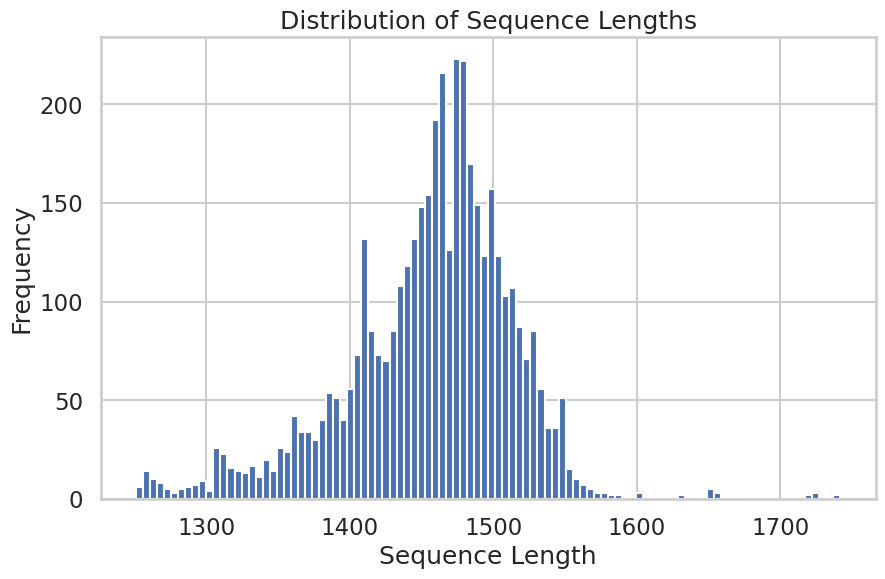

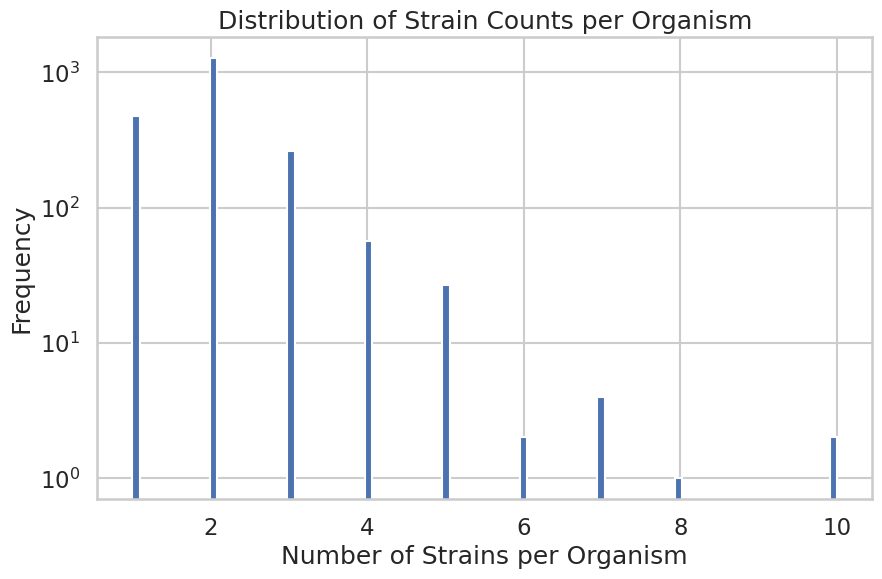

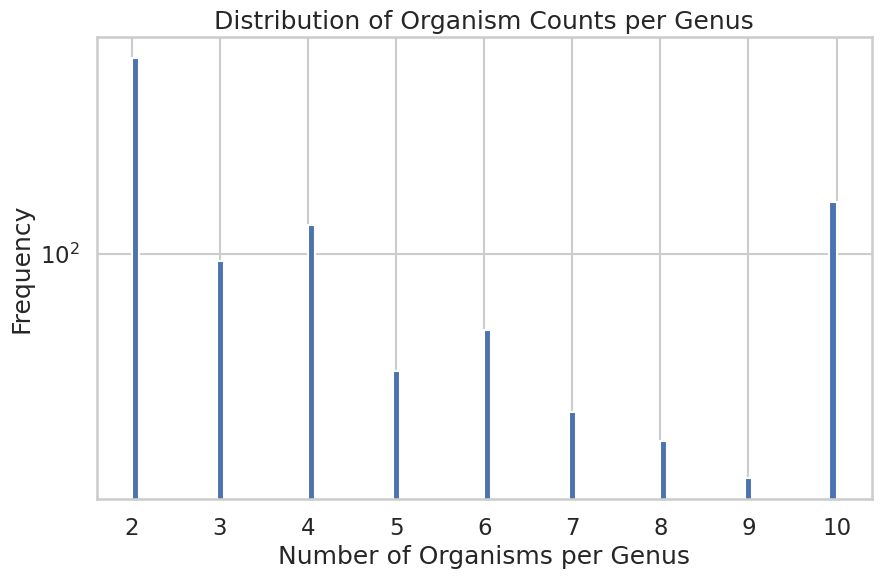

Streptomyces:		10
Paenibacillus:		10
Nocardia:		10
Pseudomonas:		10
Prevotella:		10
Erwinia:		10
Mucilaginibacter:		10
Erythrobacter:		10
Yersinia:		10
Cellulomonas:		10
Lysinibacillus:		10
Natronococcus:		10
Sporolactobacillus:		10
Herbaspirillum:		10
Methylobacterium:		10
Dietzia:		10
Dactylosporangium:		10
Exiguobacterium:		10
Pantoea:		10
Segatella:		10
Amycolatopsis:		10
Legionella:		10
Pasteurella:		10
Methylorubrum:		10
Sphingobium:		10
Thermococcus:		10
Gordonia:		10
Streptosporangium:		10
Brevundimonas:		10
Vreelandella:		10
Brucella:		10
Faecalicatena:		10
Listeria:		10
Halorubrum:		10
Chryseobacterium:		10
Nonomuraea:		10
Xenorhabdus:		10
Pseudonocardia:		10
Tsukamurella:		10
Natrinema:		10
Lacticaseibacillus:		10
Sphingobacterium:		10
Sinorhizobium:		10
Photorhabdus:		10
Roseateles:		10
Thermoanaerobacter:		10
Spiroplasma:		10
Desulfolucanica:		10
Pelosinus:		10
Agrobacterium:		10
Rickettsia:		10
Capnocytophaga:		10
Gluconobacter:		10
Gluconacetobacter:		10
Bifidobacterium:

,organism,genus,strain,len_seq,sequence
24181,Streptomyces kurssanovii,Streptomyces,NBRC 13192,1461,AACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGATGAACCAC...
11456,Streptomyces pratensis,Streptomyces,ch24,1370,CGATGAAGCCCTTCGGGGTGGATTAGTGGCGAACGGGTGAGTAACA...
20842,Streptomyces yerevanensis,Streptomyces,NBRC 12517,1453,TAACACATGCAAGTCGAACGATGAACCCGCTTCGGTGGGGGATTAG...
20701,Streptomyces werraensis,Streptomyces,NBRC 13404,1474,ACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGATGAAC...
23022,Streptomyces prasinus,Streptomyces,NRRL B-2712,1498,AGTTTGATTCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACACA...
...,...,...,...,...,...
24874,Natronorubrum aibiense,Natronorubrum,7-3,1473,ATTCCGGTTGATCCTGCCGGAGGTCATTGCTATTGGAGTCCGATTT...
20302,Empedobacter brevis,Empedobacter,NBRC 14943,1444,GATGAACGCTAGCGGGAGGCCTAACACATGCAAGCCGAGGGGTACG...
22554,Empedobacter brevis,Empedobacter,LMG 4011,1485,TAGAGTTTGATCCCTGGCTCAGGATGAACGCTAGCGGGAGGCCTAA...
20297,Saccharicrinis fermentans,Saccharicrinis,NBRC 15936,1448,GATGAACGCTAGCGACAGGCCTAACACATGCAAGTCGAGGGGTAAC...


In [27]:
df = pd.read_csv("data/sequence.txt", sep="\t")
df = df[df['seq'] == ' partial sequence']
print(df.shape)
df["len_seq"] = df["Unnamed: 2"].apply(len)
df = df[(df["len_seq"] >= 1250) & (df["len_seq"] <= 1750)]
df[['accession', 'organism', 'strain']] = df.id.str.extract(r'^(NR_\d+\.\d+)\s+(.+?)\s+strain\s+(.+?)\s+16S ribosomal RNA$')
strain_counts = df['organism'].value_counts()
organisms_to_keep = strain_counts[strain_counts > 1].index
df = df[df['organism'].isin(organisms_to_keep)]
df = df[['organism', 'strain', 'len_seq', 'Unnamed: 2']]
df = df.rename(columns={'Unnamed: 2': 'sequence'})
df['genus'] = df['organism'].apply(lambda x: x.split()[0])
print(df.shape)
df.dropna(inplace=True)
print(df.shape)
df = df[['organism', 'genus', 'strain', 'len_seq', 'sequence']]

genus_counts = df['genus'].value_counts()
# randomly subsample same number of strains from each genus
dfs = []
for genus, count in genus_counts.items():
    df_genus = df[df['genus'] == genus]
    if count > 10:
        df_genus = df_genus.sample(n=10, random_state=42)
    dfs.append(df_genus)
df = pd.concat(dfs)

print(df.shape)
# print(df.head())
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df["len_seq"], bins=100)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()

# number of strains in organisms with more than 10 strains
strain_counts = df['organism'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(strain_counts, bins=100)
plt.xlabel("Number of Strains per Organism")
plt.ylabel("Frequency")
plt.title("Distribution of Strain Counts per Organism")
plt.yscale('log')
plt.show()

genus_counts = df['genus'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(genus_counts, bins=100)
plt.xlabel("Number of Organisms per Genus")
plt.ylabel("Frequency")
plt.title("Distribution of Organism Counts per Genus")
plt.yscale('log')
plt.show()

sorted_genus_counts = genus_counts.sort_values(ascending=False)
for organism, count in sorted_genus_counts.items():
    print(f"{organism}:\t\t{count}")

df

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/sequence-cleaner.txt", sep="\t")
sns.set_theme(style="whitegrid", context="talk")

# Make a copy and clean types
plot_df = df.copy()
# Ensure len_seq is numeric
plot_df['len_seq'] = pd.to_numeric(plot_df['len_seq'], errors='coerce')
plot_df = plot_df.dropna(subset=['genus', 'len_seq'])

# Pick top N genera by number of sequences
top_n = 15
counts = plot_df['genus'].value_counts()
top_genera = counts.head(top_n).index
plot_top = plot_df[plot_df['genus'].isin(top_genera)]

# Prepare data for barplot (counts) and consistent ordering
bar_df = counts.loc[top_genera].sort_values(ascending=True).reset_index()
bar_df.columns = ['genus', 'n']
order = list(bar_df['genus'])

# Build the figure with two panels:
# - Left: horizontal bar chart of counts per genus
# - Right: violin (with quartiles) of sequence length per genus
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(1, 2, width_ratios=(1, 1.3), wspace=0.25)

# Panel A: counts
ax0 = fig.add_subplot(gs[0, 0])
palette = sns.color_palette("viridis", n_colors=len(order))
sns.barplot(data=bar_df, x='n', y='genus', order=order, palette=palette, ax=ax0)
ax0.set_title(f"Top {len(order)} genera by number of sequences")
ax0.set_xlabel("Number of sequences")
ax0.set_ylabel("Genus")

# Annotate counts
xmax = bar_df['n'].max()
for y, n in enumerate(bar_df['n']):
    ax0.text(n + xmax * 0.01, y, str(int(n)), va='center', fontsize=11)

# Panel B: sequence length distribution per genus
ax1 = fig.add_subplot(gs[0, 1])
sns.violinplot(
    data=plot_top, y='genus', x='len_seq',
    order=order, orient='h', cut=0, inner='quartile',
    scale='width', palette=palette, ax=ax1
)
ax1.set_title("Sequence length distribution by genus")
ax1.set_xlabel("Sequence length (bp)")
ax1.set_ylabel("")

# Optional: tidy up spines
for ax in (ax0, ax1):
    sns.despine(ax=ax, left=True, bottom=True)

fig.suptitle("16S dataset overview", y=0.98)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/sequence-cleaner.txt'

In [29]:
df.to_csv("data/sequence-filtered.tsv", sep="\t", index=False)

In [23]:
MODEL_CHECKPOINT = "zhihan1996/DNABERT-2-117M"
config = BertConfig.from_pretrained(MODEL_CHECKPOINT, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, trust_remote_code=True)
model = AutoModel.from_config(config)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [24]:
# Read in the new sequence data and run head to see the overall data structure
data_in = df
inputs = tokenizer(data_in.seq.to_list())["input_ids"]
print(inputs[0])


[1, 2061, 25, 222, 23, 224, 143, 3411, 403, 247, 53, 150, 527, 2759, 2834, 2734, 724, 873, 81, 118, 2470, 30, 708, 72, 61, 679, 29, 200, 88, 2894, 71, 117, 639, 72, 1478, 315, 137, 2787, 825, 1826, 966, 189, 1235, 45, 229, 4079, 314, 1340, 835, 427, 138, 316, 99, 120, 2139, 76, 36, 987, 75, 315, 8, 0, 41, 199, 0, 0, 5, 778, 460, 632, 59, 100, 72, 26, 0, 1212, 1527, 71, 148, 281, 0, 9, 3558, 238, 92, 635, 59, 111, 556, 2787, 135, 52, 259, 64, 72, 31, 120, 469, 2816, 50, 2638, 166, 29, 135, 1262, 31, 141, 17, 495, 1170, 317, 32, 443, 79, 78, 30, 619, 36, 247, 137, 1517, 2810, 19, 153, 1826, 20, 277, 1080, 332, 159, 15, 583, 458, 61, 783, 18, 486, 17, 540, 29, 200, 14, 183, 22, 236, 168, 37, 282, 3453, 71, 7, 0, 3386, 34, 123, 315, 103, 265, 194, 50, 42, 534, 171, 259, 166, 112, 2394, 200, 106, 59, 118, 1952, 409, 577, 117, 124, 1832, 0, 113, 205, 35, 553, 403, 38, 499, 16, 605, 788, 212, 8, 0, 0, 9, 3382, 169, 194, 233, 368, 38, 2785, 1149, 282, 1435, 66, 101, 39, 386, 8, 0, 9, 10, 846, 

In [26]:
# Helper function to count trainable parameters
def print_trainable_parameters(model):
    """Count and display trainable vs total parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    
    trainable_pct = 100 * trainable_params / all_param
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_param:,}")
    print(f"  Trainable: {trainable_pct:.2f}%")

# Configure LoRA
lora_config = LoraConfig(
    r=8,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["query", "value"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)

print("📊 Model Parameters Comparison:")
print("-" * 60)
print("Before LoRA (original model):")
# print_trainable_parameters(AutoModel.from_pretrained(MODEL_CHECKPOINT))
print("\nAfter LoRA (adapted model):")
print_trainable_parameters(ft_model)
print("-" * 60)
print("\n✓ LoRA adapters applied successfully!")

🔄 Applying LoRA adapters to model...

📊 Model Parameters Comparison:
------------------------------------------------------------
Before LoRA (original model):

After LoRA (adapted model):
  Trainable params: 294,912
  Total params: 89,481,984
  Trainable: 0.33%
------------------------------------------------------------

✓ LoRA adapters applied successfully!
